In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

import theano
import theano.tensor as T

### Reading inputs

In [4]:
answer_cols = ["Ans_"+str(i+1) for i in range(30)]
N = len(answer_cols)   # Number of questions
L = 6                # Number of possible answers

## Reading user info
U = pd.read_csv('input_to_algorithm.csv', index_col=0, low_memory=False)
M = len(U) # Number of users
assert U.shape[1], N
print "Users input size (M x N): ", U.shape

ans_enc = OneHotEncoder(sparse=False)
U = ans_enc.fit_transform(U)
U = U.reshape(M, N, L)
print "One-hot (M x N x L):", U.shape, "\n"

## Reading party info
P = pd.read_csv('es_party_XYZ.csv', delim_whitespace=True)
P = P[answer_cols]
P[P==99] = 6
K = len(P) # Number of parties
print "Parties input size (K x N): ", P.shape

P = ans_enc.transform(P)
P = P.reshape(len(P), len(answer_cols), L)
print "One-hot (K x N x L):", P.shape, "\n"

## Reading voting intention
V = pd.read_csv('voting_intention.csv', header=None,index_col=0)
assert len(V), M
print "Voting intention input size (M):", len(V)

party_enc = OneHotEncoder(sparse=False)
V = party_enc.fit_transform(V)
assert K, V.shape[1]
print "One-hot (M x K)", V.shape, "\n"

Users input size (M x N):  (69037, 30)
One-hot (M x N x L): (69037, 30, 6) 

Parties input size (K x N):  (10, 30)
One-hot (K x N x L): (10, 30, 6) 

Voting intention input size (M): 69037
One-hot (M x K) (69037, 10) 



### Building model

In [5]:
# Symbolic variables
u = T.dtensor3("u")
p = T.dtensor3("p")
v = T.dmatrix("v")

rng = np.random

# Define learnable parameters (with random initialization)
d = theano.shared(rng.randn(N, 13), name="D") # 13 independent weights in the bi-symmetrical distance matrix

D = []
for j in range(N):
    D_w = d[j]
    D0 = T.stack([D_w[0], D_w[1], D_w[3], D_w[6], D_w[8], D_w[9]])
    D1 = T.stack([D_w[1], D_w[2], D_w[4], D_w[7], D_w[6], D_w[10]])
    D2 = T.stack([D_w[3], D_w[4], D_w[5], D_w[4], D_w[3], D_w[11]])
    D3 = T.stack([D_w[6], D_w[7], D_w[4], D_w[2], D_w[1], D_w[10]])
    D4 = T.stack([D_w[8], D_w[6], D_w[3], D_w[1], D_w[0], D_w[9]])
    D5 = T.stack([D_w[9], D_w[10], D_w[11], D_w[10], D_w[9], D_w[12]])
    D.append(T.stack([D0,D1,D2,D3,D4,D5]))

D = T.stack(D)                               
w = theano.shared(rng.randn(N), name="w")

# Compute distance scores
s = T.batched_dot(u.dimshuffle((1,0,2)), D)#.swapaxes(1,0))#D.dimshuffle((1,0,2)))
sd = T.batched_dot(s, p.dimshuffle((1,2,0)))
#s = T.nnet.sigmoid(s)

# Aggregate issues with weights
#w = w.dimshuffle((0,'x','x'))
s = T.tensordot(sd, w, axes=[[0],[0]])
#s = T.nnet.sigmoid(s)
s = T.nnet.softmax(s)

### Training model

In [6]:
training_steps = 80000
lambda0 = 0.001 # regularization parameter
mu = 1 # learning rate

err = T.nnet.categorical_crossentropy(s,v)
cost = err.mean() + lambda0 * ((w ** 2).sum() + (d ** 2).sum())
gw, gd = T.grad(cost, [w, d])

# Compile
train = theano.function(
          inputs=[u,p,v],
          outputs=[s, err],
          updates=((w, w - mu * gw), (d, d - mu * gd)))
predict = theano.function(inputs=[u,p], outputs=s)

# Train
err_vec = np.zeros(training_steps)
for i in range(training_steps):
    pred, error = train(U, P, V)
    err_vec[i] = error.mean()
    
    v_max = np.argmax(V,axis=1)
    p_max = np.argmax(predict(U,P),axis=1)
    acc = sum(v_max == p_max) / float(M)
    
    print "{:d}, {:.5f}, {:.5f}".format(i, err_vec[i], acc)
    
print("Final model:")
print(w.get_value())
print(d.get_value())
print("target values for D:")
print(V)
print("prediction on D:")
print(predict(U,P))

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


0, 5.60916, 0.21667
1, 3.42926, 0.22846
2, 2.80130, 0.23454
3, 2.45396, 0.24093
4, 2.24761, 0.24693
5, 2.12129, 0.25200
6, 2.03843, 0.25709
7, 1.97954, 0.26248
8, 1.93522, 0.26621
9, 1.90054, 0.26961
10, 1.87262, 0.27280
11, 1.84967, 0.27575
12, 1.83051, 0.27886
13, 1.81433, 0.28156
14, 1.80052, 0.28443
15, 1.78864, 0.28690
16, 1.77833, 0.28935
17, 1.76931, 0.29174
18, 1.76134, 0.29412
19, 1.75425, 0.29590
20, 1.74788, 0.29767
21, 1.74211, 0.29903
22, 1.73687, 0.30022
23, 1.73206, 0.30184
24, 1.72762, 0.30332
25, 1.72352, 0.30494
26, 1.71971, 0.30669
27, 1.71615, 0.30837
28, 1.71283, 0.30957
29, 1.70970, 0.31022
30, 1.70676, 0.31117
31, 1.70398, 0.31257
32, 1.70136, 0.31363
33, 1.69887, 0.31443
34, 1.69651, 0.31535
35, 1.69425, 0.31612
36, 1.69211, 0.31695
37, 1.69005, 0.31825
38, 1.68808, 0.31905
39, 1.68620, 0.31963
40, 1.68438, 0.32086
41, 1.68263, 0.32141
42, 1.68095, 0.32199
43, 1.67932, 0.32260
44, 1.67774, 0.32307
45, 1.67621, 0.32374
46, 1.67472, 0.32436
47, 1.67327, 0.32478
48

KeyboardInterrupt: 

In [45]:
v_max = np.argmax(V,axis=1)
p_max = np.argmax(predict(U,P),axis=1)
acc = sum(v_max == p_max) / float(M)
acc

0.3839773194017291

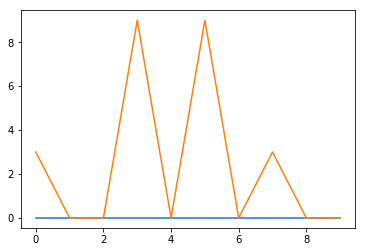

In [7]:
plt.plot(v_max[:10])
plt.plot(p_max[:10])
w_a = w
d_a = d

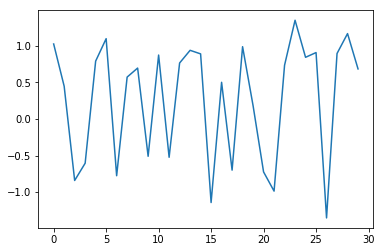

In [8]:
plt.plot(w.get_value())

In [9]:
print(d.get_value())

[[ 9.90302794e-01  2.76553065e-01  1.34808663e-02 -3.21585505e-02
  -3.85242341e-02  9.81122821e-02 -2.52856447e-01 -1.28245935e-01
  -2.58402032e-01  5.25660514e-02 -1.48997778e-01 -2.57458213e-02
   7.22362909e-02]
 [ 2.31945543e-01  2.38246068e-01  2.08857701e-01  3.86632547e-02
   1.42201891e-01 -6.08561678e-02 -3.16325406e-01 -2.64221286e-02
  -1.38565365e-01  4.88832593e-02  4.81768258e-02  5.02533779e-02
   1.19606075e-01]
 [ 4.37560922e-01  9.69453283e-02 -2.39306005e-01  2.19856061e-01
  -1.41423708e-01 -2.04054342e-02 -1.65350689e-02 -4.41249397e-01
   4.94795153e-01 -5.91104933e-02 -1.12576703e-01 -1.28730039e-01
   2.36515573e-02]
 [-1.47509465e-01 -2.64099726e-01 -2.38278365e-01 -1.91438277e-02
   3.04098701e-03 -2.86823131e-02  1.94110125e-01 -3.97259939e-03
   4.03513093e-01 -2.23174687e-01 -2.61747353e-01 -2.73702356e-02
  -1.90057334e-01]
 [ 6.47047216e-01 -1.69085418e-02 -3.67194972e-01 -1.05689042e-02
   4.98983678e-02  1.10219877e-02 -2.71060517e-01 -1.63476351e-01


In [10]:
pred = predict(U,P)
pred[7]

array([0.13068396, 0.26631015, 0.05175572, 0.29272386, 0.04306092,
       0.00508399, 0.00512461, 0.02324376, 0.01953231, 0.16248072])

In [12]:
pred[1]

array([0.2990467 , 0.18193121, 0.10829661, 0.09108438, 0.11615706,
       0.04311007, 0.03331088, 0.07713861, 0.02373448, 0.02618999])

In [ ]:
T.nnet.confusion_matrix

In [70]:
theano.printing.pprint(s)
#theano.printing.debugprint(s)
#theano.printing.pydotprint(s, outfile="pics/graph.png")

'Softmax(Reshape{2}((Reshape{2}(DimShuffle{1, 2, 0}(BatchedDot(BatchedDot(DimShuffle{1, 0, 2}(u), join(TensorConstant{0}, join(TensorConstant{0}, [D[Constant{0}][Constant{0}], D[Constant{0}][Constant{1}], D[Constant{0}][Constant{3}], D[Constant{0}][Constant{6}], D[Constant{0}][Constant{8}], D[Constant{0}][Constant{9}]], [D[Constant{0}][Constant{1}], D[Constant{0}][Constant{2}], D[Constant{0}][Constant{4}], D[Constant{0}][Constant{7}], D[Constant{0}][Constant{6}], D[Constant{0}][Constant{10}]], [D[Constant{0}][Constant{3}], D[Constant{0}][Constant{4}], D[Constant{0}][Constant{5}], D[Constant{0}][Constant{4}], D[Constant{0}][Constant{3}], D[Constant{0}][Constant{11}]], [D[Constant{0}][Constant{6}], D[Constant{0}][Constant{7}], D[Constant{0}][Constant{4}], D[Constant{0}][Constant{2}], D[Constant{0}][Constant{1}], D[Constant{0}][Constant{10}]], [D[Constant{0}][Constant{8}], D[Constant{0}][Constant{6}], D[Constant{0}][Constant{3}], D[Constant{0}][Constant{1}], D[Constant{0}][Constant{0}], D

In [77]:
predict = theano.function(inputs=[u,p], outputs=[s,sd])
scores, mid_scores = predict(U,P)
mid_scores.shape

(30, 99821, 10)

In [84]:
w.get_value().shape

(30,)

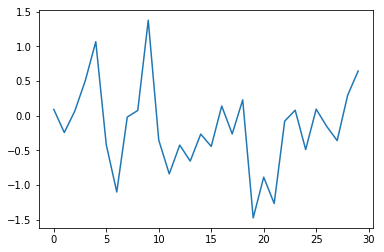

In [92]:
plt.plot(mid_scores[:,0,1] * w.get_value())

In [101]:
# Symbolic variables
u = T.dtensor3("u")
p = T.dtensor3("p")
v = T.dmatrix("v")

rng = np.random

# Define learnable parameters (with random initialization)
D = theano.shared(rng.randn(N, L, L), name="D") # 13 independent weights in the bi-symmetrical distance matrix
                             
w = theano.shared(rng.randn(N), name="w")

# Compute distance scores
s = T.batched_dot(u.dimshuffle((1,0,2)), D)#.swapaxes(1,0))#D.dimshuffle((1,0,2)))
sd = T.batched_dot(s, p.dimshuffle((1,2,0)))
#s = T.nnet.sigmoid(s)

# Aggregate issues with weights
#w = w.dimshuffle((0,'x','x'))
s = T.tensordot(sd, w, axes=[[0],[0]])
#s = T.nnet.sigmoid(s)
s = T.nnet.softmax(s)

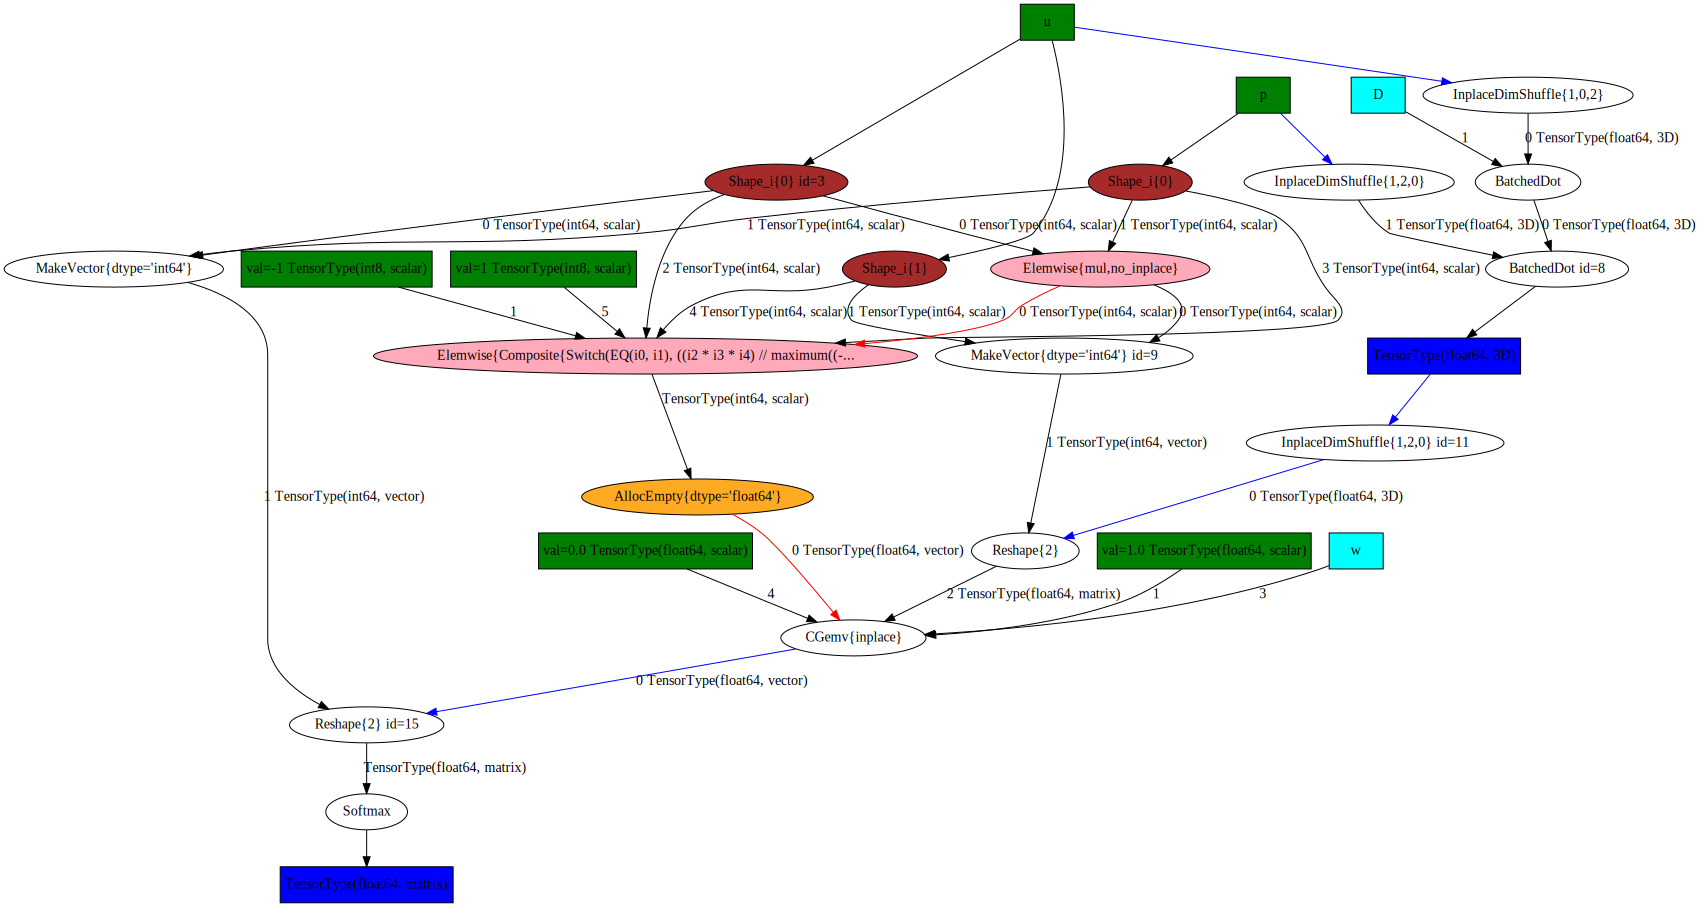

In [110]:
predict = theano.function(inputs=[u,p], outputs=[s,sd])

#theano.printing.pprint(s)
#theano.printing.debugprint(s)
from IPython.display import SVG
SVG(theano.printing.pydotprint(predict, outfile="pics/graph.png", var_with_name_simple=True, return_image=True, format='svg'))

In [122]:
import theano.d3viz as d3v
d3v.d3viz(predict, 'pics/graph.html')

In [13]:
import pickle
with open('data.pickle', 'wb') as f:
    pickle.dump([w.get_value(),d.get_value()], f)

In [127]:
d_a.get_value()

array([[-8.58857997e-01, -1.70478047e-01,  1.19666089e-01,
        -4.49163585e-02,  3.55358348e-03, -2.72079617e-01,
         2.88252463e-01,  2.38997732e-01,  2.31804570e-01,
         6.41516361e-02,  2.92135259e-01,  1.45936464e-02,
        -4.68532185e-02],
       [ 3.06451172e-01,  2.26347790e-01,  1.19026293e-01,
        -5.73799385e-02, -1.54429478e-02,  2.60553782e-02,
        -2.59181701e-01, -9.72348173e-02, -1.14274108e-01,
         5.19895271e-02, -7.34816088e-02, -1.48195275e-01,
        -5.22551896e-02],
       [-2.74328784e-01, -1.03213277e-01,  8.22242440e-02,
        -1.07174059e-01,  1.13946877e-01, -4.07567981e-02,
         6.52472260e-02,  3.64301794e-01, -2.74005230e-01,
        -3.17625545e-02,  3.24611709e-02,  2.67900491e-02,
        -4.75244003e-02],
       [ 2.32912795e-01,  2.36909243e-01,  1.25954154e-01,
        -2.31076298e-02, -4.70671559e-02, -8.81748438e-02,
        -1.96667208e-01, -9.73872633e-02, -3.86708163e-01,
         1.53640107e-01,  7.52635726e